In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.Functions import calc_Truths, Sensitivity, profile, get_Data_Bkg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc,recall_score,precision_score,mean_squared_error
import time
import xgboost as xgb

# Step 1: Data Investigation
---
    
<b> We firstly want to load in our data and have a look at it. This comes in the form of two files: one filled with information on our Higgs boson events, and another filled with events which look similar but don't contain Higgs bosons. 

We will combine these two files so that they become one big one, and from there we can plot the data in each column to get to grips with what each quantity is.
    
The files are organised so that each row contains data on a different collision, and each column is a different 'feature' of that collision. We refer to features in machine learning as the different quantites that all items in a dataset have. For example, some features we have here are the momentum, energy, and emission angles of two photons detected by ATLAS.

In [68]:
#Read in the training data
nrows = 1000000
sig_df = pd.read_csv('./../CSVfiles/ggF_data.csv',nrows=nrows)
bkg_df = pd.read_csv('./../CSVfiles/yyjj_data.csv', nrows=nrows)

#Or, to use non-simulated background data, run this line instead
#bkg_df = get_Data_Bkg(nrows)

#Confirm how much signal and background data there is
num_sigs = len(sig_df)
num_bkgs = len(bkg_df)
prop = (num_sigs/(num_bkgs+num_sigs))
print('There is %.2f%% signal data' % (prop*100))

#Full MC dataset 
df = pd.concat([sig_df,bkg_df])

#Transform data to remove mass bias 
df['g1_pt'] = df['g1_pt']/(df['p_mass'])
df['g2_pt'] = df['g2_pt']/(df['p_mass'])
df['g1_E'] = df['g1_E']/(df['p_mass'])
df['g2_E'] = df['g2_E']/(df['p_mass'])

#This displays a summary of our data set
print(df.head())

There is 50.00% signal data
   label   p_mass  photon_sep       g1_pt    g1_eta    g1_phi         g1_E  \
0    1.0  127.490    3.316441  566.862499  1.226050 -3.079520  1049.031297   
1    1.0  124.116    4.073062  617.511844 -2.114160  2.468650  2594.596990   
2    1.0  126.525    3.344683  802.805770 -0.031019 -1.842830   803.193045   
3    1.0  126.623    2.571210  662.070872 -1.072780  0.074279  1081.012138   
4    1.0  125.641    2.783365  564.874523  1.836840  0.330306  1817.758534   

        g2_pt    g2_eta    g2_phi  ...    j1_pt    j1_eta    j1_phi      j1_E  \
0  322.562554  0.077793  0.031796  ...      NaN       NaN       NaN       NaN   
1  263.754874 -0.649200 -1.331840  ...  48849.5 -1.022350 -0.718654   76999.9   
2  278.152934  0.659057  1.429890  ...  69336.4 -2.930580  0.446698  651481.0   
3  387.465942 -1.590400 -2.444290  ...      NaN       NaN       NaN       NaN   
4  430.063435  2.360420 -2.403370  ...  30038.4  0.413759  2.742460   33295.3   

   j1_BTAG    j2

<b> You will see a summary of our data above, but it's impossible to understand the distribution of each column based soley on this. In the next cell, we will try writing a piece of code to plot out some of the columns.
    
As this is a Pandas DataFrame (which we called 'df'), you'll need to know how to access these values. There is a template included to help you with this. You can select a single column by typing df['insert_column_name'] (include the quotations as the column name should be a string!), and this will return a Pandas Series of the column. At some points in this Notebook you'll see df['insert_column_name'].values instead, this returns a NumPy array, and is used when one is required over a Series. You can look up the documentations of each for more in-depth explinations of these structures.

In [ ]:
#Try plotting some columns here! You can alter the column name and number of bins too
plt.hist(df['insert_column_name'])
plt.show()

<b> The code for this cell will be used to calculate some extra terms which we will use later on.

In [69]:
#Read in scale factor data
sf1 = pd.read_csv('./../CSVfiles/ggF_sf.csv',nrows=nrows)
sf2 = pd.read_csv('./../CSVfiles/yyjj_sf.csv', nrows=nrows)

#Or, if using non-simulated background data, run these lines instead
#sf2 = pd.Series(1, index =list(range(len(bkg_df))))
#sf = pd.concat([sf1['mcweight'],sf2], ignore_index=True, axis = 0)

sf = pd.concat([sf1['mcweight'],sf2['mcweight']], ignore_index=True, axis = 0)

#Split MC data into training and validation sets
#This code gives 20% to the validation set
x_train, x_val, y_train, y_val, m_train, m_val, sf_train, sf_val = train_test_split(df.iloc[:, 2:],
                                                                  df['label'], df['p_mass'].values,
                                                                  sf.values,
                                                                  test_size=0.2, shuffle = True)

#Convert to dtype which XGBoost uses
dtrain = xgb.DMatrix(data = x_train, label = y_train)
dval = xgb.DMatrix(data = x_val, label = y_val)

#Start calculating scale factors
SB_ggjj = len(bkg_df[(bkg_df['p_mass'] < 121) | (bkg_df['p_mass'] > 129)]) #Number of events in background side bands
sf_trim = [len(df[df['label']==1])/len(y_val[y_val==1]), len(df[df['label']==0])/len(y_val[y_val==0])] #data split scale factors

#Clear unnecessary memory use
del df, sig_df, bkg_df, sf1, sf2, sf

#Read in raw ATLAS data, we need to use this to calculate more scale factors
df1 = pd.read_csv('./../CSVfiles/data15_data.csv')
df2 = pd.read_csv('./../CSVfiles/data16_p1_data.csv')

df3 = pd.concat([df1,df2])
del df1,df2

df4 = pd.read_csv('./../CSVfiles/data16_p2_data.csv')
df5 = pd.read_csv('./../CSVfiles/data16_p3_data.csv')

df6 = pd.concat([df4,df5])
del df4,df5

df = pd.concat([df3,df6])
del df3,df6

SB_data = len(df[(df['p_mass'] < 121) | (df['p_mass'] > 129)]) #Number of events in raw data side bands
SF_band = SB_data/SB_ggjj #Side band scale factor

#Clear unnecessary memory use
del df

# Step 2: Train the Model
---

<b> Now that our data is in its correct form and we've had a look at it, we can pass it into a machine learning (ML) algorithm. 

For this project, we will be using an implementation of Boosted Decision Trees known as XGBoost. Importing XGBoost allows us to easily train our classifier. 
    
In order to train our ML model, we will need to have 'labelled' data. This means that we need to know - before training - what to classify each collision event as: either resulting from signal, or background processes. This is a hard task, after all it's why we need the classifier in the first place! Luckily the scientsits at CERN are able to generate simulated events which we can label with certainty. This way, after we train the ML algorithm on the simulated data, it should be good enough to distinguish between signal and background events in the real data too.
    
We should be careful here to only train on our training set. The reason that we split up the data into training and validation sets is to avoid overfitting our classifier. When overfitting occurs, the classifier becomes so well tuned to the data that it is no longer effective. We can tell if this happens by using the validation set. If the classification error on the validation set becomes much larger than on the training set, the model is overfitted.
    
As the model trains, you should see the error on each iteration descend, this is the model 'learning' and is how it makes better and better classifications!

In [70]:
#Set error function, nthread is for No. CPU threads
#Watchlist prints error statistics, num_round is number of iterations
param = {'objective':'binary:logistic', 'nthread': '-1'}
watchlist = [(dtrain, 'train'),(dval, 'eval')]
num_round = 100

#Fit the model to the training data
training_start = time.perf_counter()
model = xgb.train(param, dtrain, num_round, watchlist)  #This line initiates training
training_end = time.perf_counter()

[15:44:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66810	eval-logloss:0.66814
[1]	train-logloss:0.65366	eval-logloss:0.65408
[2]	train-logloss:0.64535	eval-logloss:0.64582
[3]	train-logloss:0.64018	eval-logloss:0.64060
[4]	train-logloss:0.63660	eval-logloss:0.63722
[5]	train-logloss:0.63378	eval-logloss:0.63447
[6]	train-logloss:0.63210	eval-logloss:0.63290
[7]	train-logloss:0.63042	eval-logloss:0.63135
[8]	train-logloss:0.62913	eval-logloss:0.63012
[9]	train-logloss:0.62839	eval-logloss:0.62943
[10]	train-logloss:0.62745	eval-logloss:0.62861
[11]	train-logloss:0.62651	eval-logloss:0.62770
[12]	train-logloss:0.62603	eval-logloss:0.62732
[13]	train-logloss:0.62568	eval-logloss:0.62704
[14]	train-logloss:0.62504	e

<b> Below, we rank which features of the data have allowed our model to learn the most. This is useful as it gives us insight into what the model is doing/learning about, and could highlight potential problems.
    
We notice that the best features for discrimination are the second/first photon momenta, the first jet momentum, and the angle between the photons.

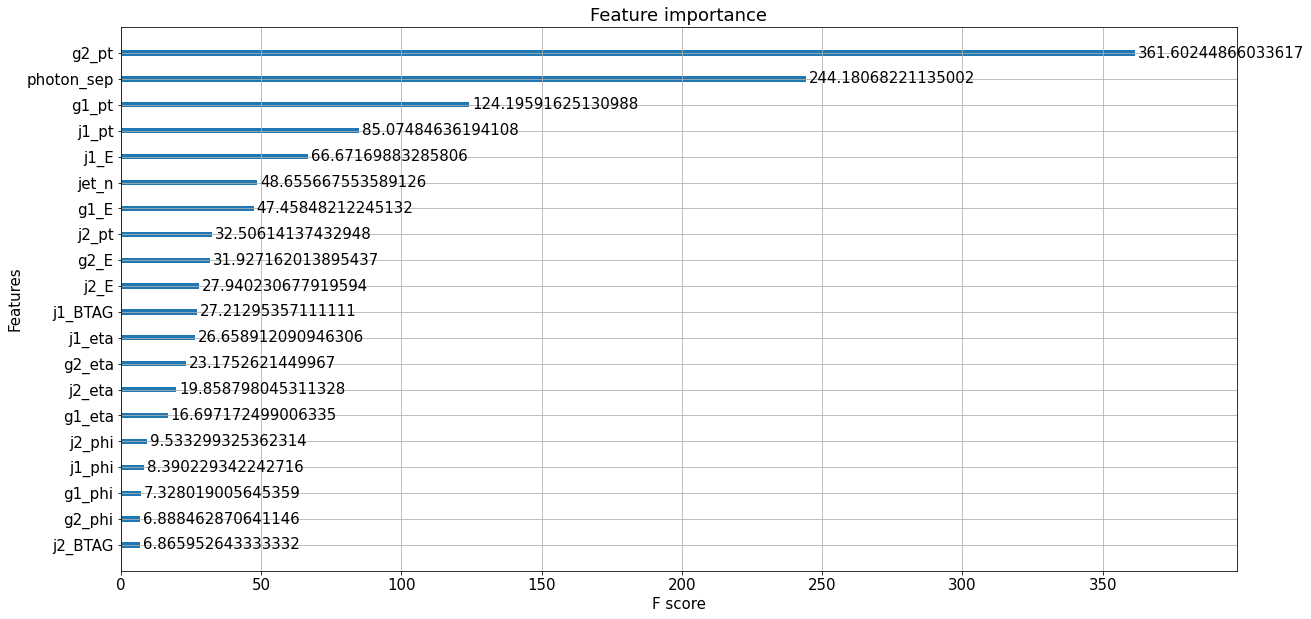

In [71]:
#Demonstrate the feature importances
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = [20,10]
xgb.plot_importance(model, importance_type='gain')
plt.show()

# Step 3: Evaluate the Model
---
<b> Now that we have a trained classifier, we can use it to predict labels of the non-simulated data. 
We evaluate our model by comparing our predictions to the labels that we know are correct. From this, many metrics can be gathered.
Generating an Reciever Operating Characteristic (ROC) curve is a good way to tell us about how well the classifier has performed. This curve plots the false positive rate against the true positive rate of the classifier, and tells us about the proportions of each class which are correctly classified. The dotted red line would indicate a classifier which is simply guessing at labels, whereas a line which bends into the top left corner is better.
    
This is a better metric than accuracy, as accuracy can mask class imbalance. An example of this would be a toy factory. If 100 toys are manufactured at a factory, and out of those hundered only 3 are faulty, a classifier could be 97% accurate by simply predicting non-faulty every time. The ROC curve tells us how many out of each class we got correct, and so is preferred.

Training time was: 89.10 seconds
Prediction time was: 0.13 seconds
Number of correct predictions:  259231  and number of incorrect:  140769
Accuracy: 64.81%


<Figure size 1200x600 with 0 Axes>

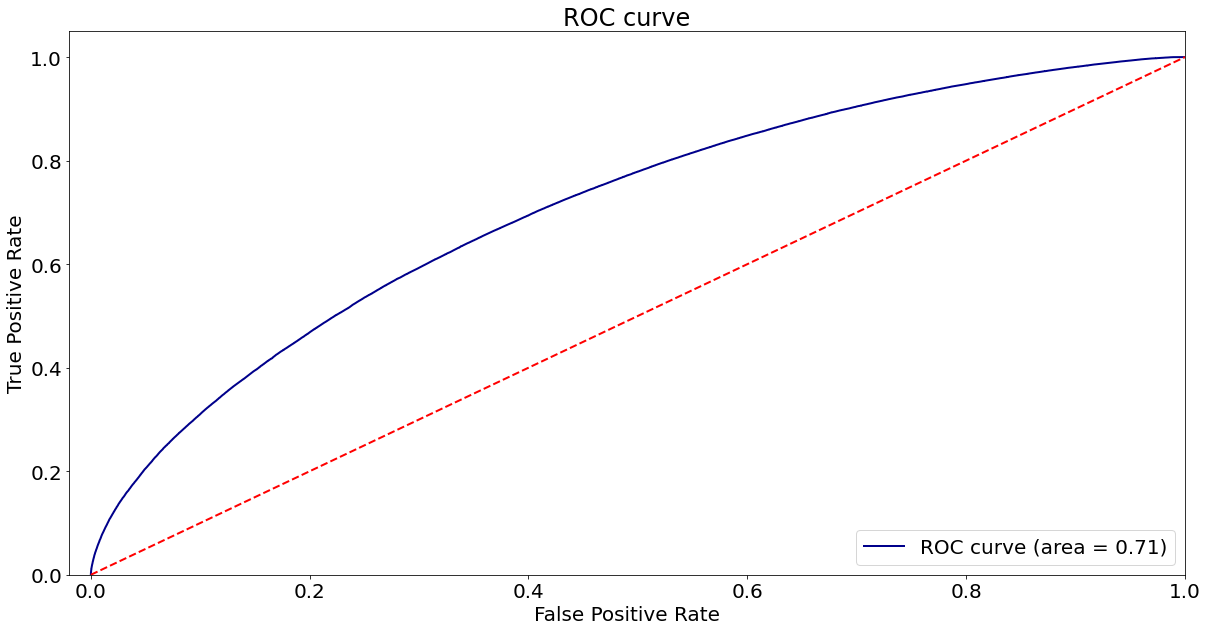

In [72]:
#To observe model behaviour, compare original labels to validation set
prediction_start = time.perf_counter()
predictions = model.predict(dval) #This line generates predictions from our model(floats between 0 and 1)
prediction_end = time.perf_counter()
y_preds = np.rint(predictions) #It can be useful to round our predicitons to whole numbers

#Evaluate how well the model performs

#Time efficiency
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print('Training time was: %.2f seconds'%xgb_train_time)
print('Prediction time was: %.2f seconds'%xgb_prediction_time)

trues = 0
falses = 0
labels = y_val.values
for i in range(len(labels)):
    if labels[i] == y_preds[i]:
        trues += 1
    elif labels[i] != y_preds[i]:
        falses += 1
    else:
        print('Error')

print('Number of correct predictions: ', trues, ' and number of incorrect: ', falses)

#Show accuracy
accuracy = accuracy_score(labels, y_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Plot ROC curve
plt.figure(figsize=(12,6), dpi= 100)
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)
plt.rcParams.update({'font.size': 20})
plt.figure()
plt.plot(fpr, tpr, color='darkblue',
        lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Step 4: Find the Best Sensitivity
---
<b> Before going ahead with our model and trying to predict on the non-simulated data, there is one more refinement which we can make. 
Currently our predictions are rounded to 1 and 0 based on a threshold of 0.5. While this is intuitive, this threshold number can actually be changed to give a more significant class separation. The idea behind this step is to test how well the classes are separated at various rounding thresholds. At each threshold we calculate a sensitivity, then we choose the threshold with the highest sensitivity as the cut which gives us the best class separation.
    
This is where the scale factors from the beginning come into play. When calculating the statistics, we need to account for the fact that we are using simulated data to train. The scale factors do this for us.

1688.82   126022.15   131797.08 
Sensitivity on cut 0.10:  4.75  with signal efficiency: 1.00  and rejetion: 0.99
1686.46   124564.18   130310.07 
Sensitivity on cut 0.14:  4.77  with signal efficiency: 1.00  and rejetion: 0.97
1677.96   120703.93   126563.64 
Sensitivity on cut 0.18:  4.82  with signal efficiency: 0.99  and rejetion: 0.95
1655.19   113858.95   119208.22 
Sensitivity on cut 0.23:  4.89  with signal efficiency: 0.98  and rejetion: 0.89
1618.06   104993.96   109621.58 
Sensitivity on cut 0.27:  4.98  with signal efficiency: 0.96  and rejetion: 0.82
1571.01   95865.21   99712.35 
Sensitivity on cut 0.31:  5.06  with signal efficiency: 0.93  and rejetion: 0.75
1504.13   84896.80   88659.70 
Sensitivity on cut 0.35:  5.15  with signal efficiency: 0.89  and rejetion: 0.66
1420.27   73555.70   77204.26 
Sensitivity on cut 0.39:  5.22  with signal efficiency: 0.84  and rejetion: 0.58
1310.78   62158.24   64958.36 
Sensitivity on cut 0.44:  5.24  with signal efficiency: 0.77  a

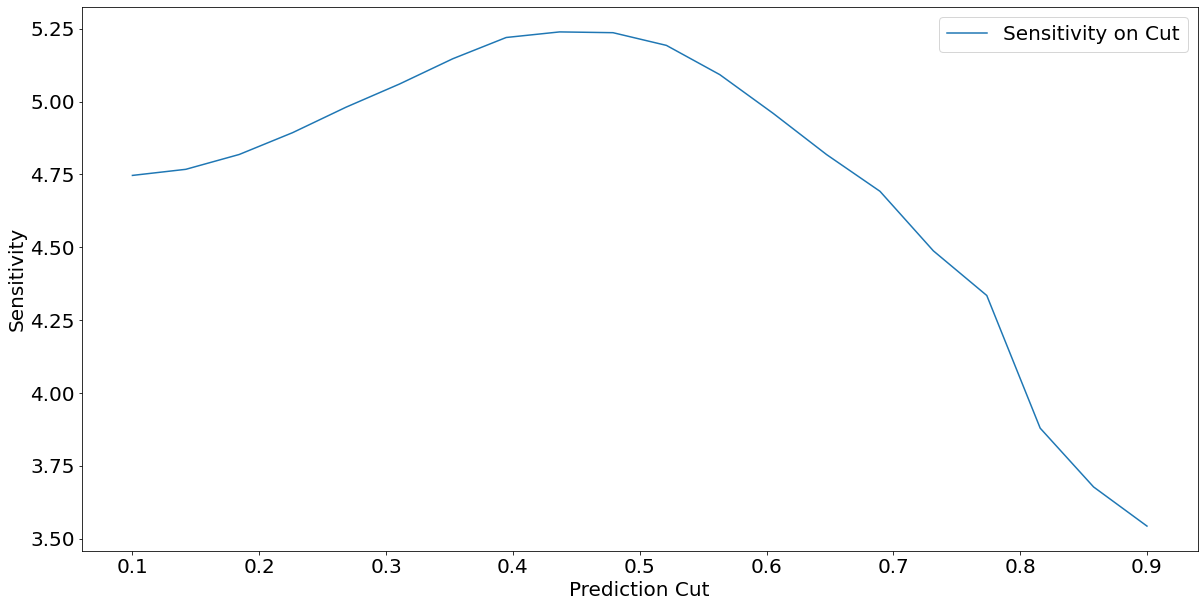

In [73]:
#Sensitivity over different cuts
ss = []
t = np.linspace(0.1,0.9,20,endpoint=True)
for i in t:
    true_pos, false_pos, true_neg, false_neg = calc_Truths(predictions, y_val.values, m_val, sf_val, threshold = i)
    eff_sig = len(true_pos)/(len(true_pos)+len(false_neg))
    eff_bkg = len(false_pos)/(len(false_pos)+len(true_neg))
    sensitivity = Sensitivity(true_pos, false_pos, sf_trim, SF_band)
    ss.append(sensitivity)
    print('Sensitivity on cut %.2f: '%i, '%.2f' % sensitivity,' with signal efficiency: %.2f' % eff_sig,' and rejetion: %.2f'% eff_bkg)
best_cut = t[ss.index(max(ss))]
print('Best at: %.2f'% best_cut)

#Plot sensitivities
plt.plot(t, ss, label = 'Sensitivity on Cut')
plt.xlabel('Prediction Cut')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

<b> We can now clearly see the cut with the best sensitivity. Let's tet this out and re-classify our simulated events based on this cut, then plot the mass spectrum of everything the classifier thinks is a Higgs Boson. The background events which make it through the threshold should be a smoothly falling blue line, and our Higgs events should be a large red spike on approximately 125 GeV.

1310.78   62158.24   64958.36 
Best signal efficiency: 0.77
Best rejection: 0.49
Best Sensitivity: 5.24


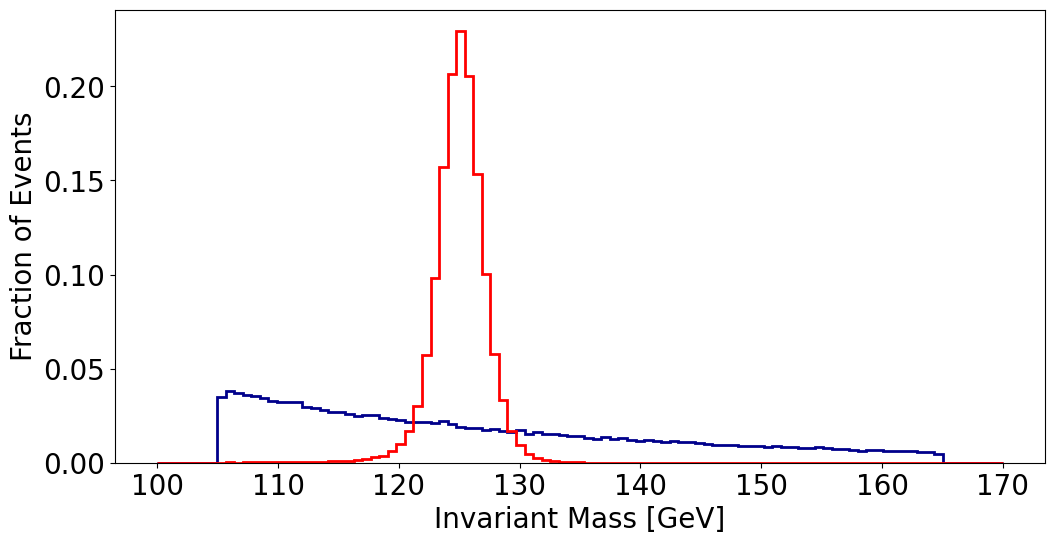

In [74]:
#If we want to 
true_pos, false_pos, true_neg, false_neg = calc_Truths(predictions, y_val.values, m_val, sf_val, threshold = best_cut)
eff_sig = len(true_pos)/(len(true_pos)+len(false_neg))
eff_bkg = len(false_pos)/(len(false_pos)+len(true_neg))
sensitivity = Sensitivity(true_pos, false_pos, sf_trim, SF_band)
print('Best signal efficiency: %.2f'%  eff_sig)
print('Best rejection: %.2f'%  eff_bkg)
print('Best Sensitivity: %.2f'%  sensitivity)

#Events passing our prediction threshold
bkgs = [i[0] for i in false_pos]  #List of background masses
sigs = [i[0] for i in true_pos]  #List of signal masses

#Plot resulting mass spectrum passing cut
plt.figure(figsize=(12,6), dpi= 100)
xlims=[100, 170]
bins = np.linspace(xlims[0],xlims[1],100,endpoint=True)
plt.hist(bkgs, color = 'darkblue', histtype='step', density = True, bins=bins,linewidth=2)
plt.hist(sigs, color = 'red', histtype='step', density = True, bins=bins,linewidth=2)
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Fraction of Events')
plt.show()

# Step 5: Find the Higgs Boson
---
<b> We now have a trained and evaluated ML model. We are now ready to apply this to the data and predict the labels. Hopefully, it will be able to predict the labels well enough for us to see the Higgs spike amongst the background processes.
    
We begin the same way as before: reading in the data and pushing it all together. We need to make sure it is in the same format as the training data, or else we won't work.

In [75]:
#Read in data
df1 = pd.read_csv('./../CSVfiles/data15_data.csv')
df2 = pd.read_csv('./../CSVfiles/data16_p1_data.csv')
df3 = pd.read_csv('./../CSVfiles/data16_p2_data.csv')
df4 = pd.read_csv('./../CSVfiles/data16_p3_data.csv')

df5 = pd.concat([df1,df2])
del df1,df2
df6 = pd.concat([df3,df4])
del df3,df4
df = pd.concat([df5,df6])
del df5,df6

df['g1_pt'] = df['g1_pt']/(df['p_mass'])
df['g2_pt'] = df['g2_pt']/(df['p_mass'])
df['g1_E'] = df['g1_E']/(df['p_mass'])
df['g2_E'] = df['g2_E']/(df['p_mass'])

x_data = df.iloc[:,1:]
m_data = df['p_mass'].values

#We can now predict labels of the data
dtest = xgb.DMatrix(data = x_data)
predictions = model.predict(dtest)
y_preds = np.rint(predictions)

<b> Our last step is to plot the mass spectrum of our predicted signal, using the best threshold cut that we calculated before. Remember that we will not see a similar mass spectrum plot as in our evaluation. This is becuase we did not know our labels beforehand for this data, making it impossible to distinguish between background and signal events which pass our cut. The red line will be all the events our classifier thinks were Higgs bosons, the actual Higgs events should appear as an excess bump on the smoothly falling background distribution.

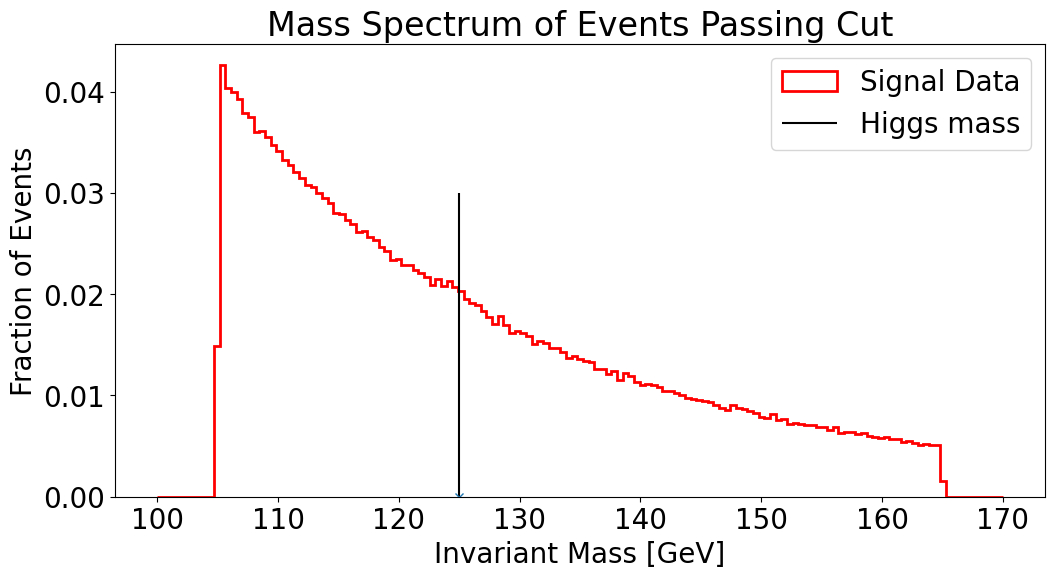

In [76]:
#Do a plot of the mass spectrum
plt.figure(figsize=(12,6), dpi= 100)
sigs = m_data[predictions >= best_cut]
bkgs = m_data[predictions < best_cut]
xlims=[100, 170]
bins = np.linspace(xlims[0],xlims[1],150,endpoint=True)
plt.hist(sigs, color = 'red', histtype='step', bins=bins,linewidth=2,label='Signal Data',density=True)
plt.vlines(125,0,0.03, label = 'Higgs mass')
plt.plot(125,0,'x')
plt.xlabel('Invariant Mass [GeV]')
plt.ylabel('Fraction of Events')
plt.title('Mass Spectrum of Events Passing Cut')
plt.legend()
plt.show()